<a href="https://colab.research.google.com/github/jarvez31/Object_representation_model/blob/main/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

### Install the extra modules

In [770]:
%reset -f

In [771]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
# tf.compat.v1.disable_eager_execution()
tf.test.is_gpu_available()

True

In [772]:
###############------------------- LOAD MODULES ---------------------#############

from tensorflow.keras.models import model_from_yaml, model_from_json
from tensorflow import keras
from functions_small_model import *
import pickle, shapely
import numpy as np
import math as mt
import tempfile
import tensorflow as tf
import pickle
from scipy import misc
import glob, csv
from tensorflow.keras import layers
from shapely.geometry import box, Polygon, Point, LinearRing
from shapely.ops import unary_union
#from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Reshape, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D, concatenate, Concatenate
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K 
from keras.regularizers import Regularizer 
# from keras_gcn import GraphConv
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from sklearn import preprocessing
from numpy import linalg as LA
import pandas as pd
from tensorflow.keras.utils import plot_model
from numpy import matlib
from progressbar import ProgressBar
import tensorflow_model_optimization as tfmot
from matplotlib import cm
main = "Bharat_local_runs/"

In [773]:
#@title Setup Parameters
fol1 = "small_model" #@param {type:"string"}
traj1 = "traj_wo_20k.pk1" #@param {type:"string"}
imgs = "frames_traj(wo)_cw_20k.pk1" #@param {type:"string"}
# traj_o = "meshgrid_obj(sh3)_30.pk1" #@param {type:"string"}
# imgs_o = "frames_mesh(obj)(sh3)_bw_30.pk1" #@param {type:"string"}

new_model_n = "train_5_vector" #@param {type:"string"}
old_model_n = "train_5_vector" #@param {type:"string"}
# fisher_n = "frames_traj(wo)_bw_20k.pk1" #@param {type:"string"}
epochs = 150 #@param {type:"number"}
lam = 1.0 #@param {type:"number"}
# lr_p = 0.1 #@param {type:"number"}
# lr_m = 0.01 #@param {type:"number"}
units = 32 #@param {type:"number"}
units2 = 64 #@param {type:"number"}
std_dev = 0.3 #@param {type:"number"}
alp = 0.0 #@param {type:"number"}
bet = 0.0 #@param {type:"number"}
gam = 1.0 #@param {type:"number"}

# test_p =  7#@param {type:"number"}
# img_fol = "traj_four_objs_diffW" #@param {type:"string"}


#@markdown ### Model Params
Retrain = False #@param {type:"boolean"}
# retrain_full = False #@param {type:"boolean"}
Train = False #@param {type:"boolean"}
Retrain_nocat = False #@param {type:"boolean"}
# Analysis = False #@param {type:"boolean"}
pre_conv = False #@param {type:"boolean"}
obj_pres = True #@param {type:"boolean"}
Do_fisher = False #@param {type:"boolean"}
# custom_loss_func = False #@param {type:"boolean"}
pi_use = "no_osc" #@param ["osc", "no_osc"]
act_func = "relu" #@param {type:"string"}
learn_rate = 0.001 #@param {type:"number"}
random_state = 42 #@param {type:"number"}

# DATA

### Trajectory

In [774]:
def obj_cent(traj_nam):
  q1, q2, q3, q4, q5 = [(0.5, 0.5), (-0.5, 0.5), (-0.5, -0.5), (0.5, -0.5), (0.0, 0.0)]
  obj_seq = [q1, q2, q3, q4, q5]
  var_chk = traj_nam[11]
  if 'sh1' in traj_nam:
    obj_c = [q1]
    obj_c_plot = [obj_seq[0]]
  elif 'sh2' in traj_nam:
    obj_c = [q2]
    obj_c_plot = obj_seq[:2]
  elif 'sh3' in traj_nam:
    obj_c = [q3]
    obj_c_plot = obj_seq[:3]
  elif 'sh4' in traj_nam:
    obj_c = [q4]
    obj_c_plot = obj_seq[:4]
  elif 'sh0' in traj_nam:
    obj_c = [(0.0, 0.0)]
    obj_c_plot = obj_seq
  elif 'mulobj1' in traj_nam:
    obj_c = [(0.0, 0.5), (0.5, 0.0), (0.0, -0.5), (-0.5, 0.0)]
    obj_c_plot = [(0.0, 0.5), (0.5, 0.0), (0.0, -0.5), (-0.5, 0.0)]
  else:
    obj_c = [(0.0, 0.0)]
    obj_c_plot = [(0.5, 0.5), (-0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)]

  return [obj_c, obj_c_plot]

  

In [775]:
def firing_rate_map(ot, all_dat, thresh_param = 0.0, title="", ticks_colbar = None, res_param = 45, sub_plot = False):
    res = res_param
    # mean_resp = np.mean(ot)
    # std_resp = np.std(ot)
    # thresh = mean_resp + (thresh_param * std_resp)
    thresh = np.max(ot)*thresh_param
    firr = np.nonzero(ot>thresh)
    firposgrid = all_dat[firr[0], :]
    #firr = list(firr[0])
    x = np.arange(-1, 1, 1/res)
    y = np.arange(-1, 1, 1/res)
    fx,fy = np.meshgrid(x, y)
    firingmap = np.zeros(fx.shape)
    firingvalue = ot[firr]
    for ii in range(len(firposgrid)):
        q1 = np.argmin(abs(firposgrid[ii,0] - fx[1,:]))
        q2 = np.argmin(abs(firposgrid[ii,1] - fx[1,:]))
        firingmap[q1,q2] = firingvalue[ii]
    firingmap = firingmap/max(np.max(firingmap),1)
    gaussian = matlab_style_gauss2D([5, 5], 1.5)
    spikes_smooth = scipy.signal.convolve2d(gaussian, firingmap)
    rotated_img = ndimage.rotate(spikes_smooth, 1*90)
    if not sub_plot:
      plt.imshow(rotated_img, origin= 'upper')
      plt.title(title)
      plt.colorbar(ticks = ticks_colbar)
      plt.clim(0,1)
      ax=plt.gca()                            # get the axis
      # ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
      # ax.set_xlim(ax.get_xlim()[::-1])        # invert the axis
      plt.show()
      # ax.xaxis.tick_bottom()                     # and move the X-Axis
      # ax.set_yticklabels([])
      # ax.set_xticklabels([])

    return rotated_img

In [776]:
def rew_new(x, y, obj_boun, present=False):
  rew = []
  if present:
    # union = unary_union(ll)
    for i in range(len(x)):
      ll = []
      for ii in obj_boun:
        bb = box(ii[0], ii[1], ii[2], ii[3])        
        kk = Point(x[i],y[i])
        if bb.contains(kk):
          ll.append(1)

      if len(ll):
        rew.append(1)
      else:
        rew.append(0)          
  else:
    rew = [0]*len(x)

  return np.asarray(rew)

[(-0.15, -0.15, 0.15, 0.15)]
359.9444045231699
20000


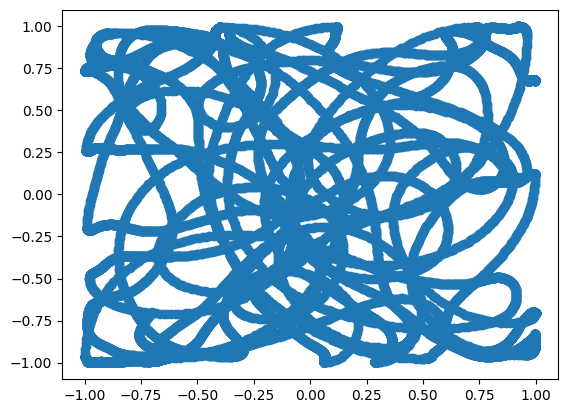

In [777]:
###--------------------- LOAD TRAJECTORY --------------------###

fol = main + fol1 + "/"
traj = traj1
with open(traj, "rb") as f:
    d = pickle.load(f)
    f.close()
locals().update(d)

if len(x) > 30000:
  x = x[:-1]
  y = y[:-1]
  theta = theta[:-1]

x = np.asarray(x)
y = np.asarray(y)
theta = np.asarray(theta)
theta = np.nan_to_num(theta, nan=45.0)
theta_rad = np.radians(theta)

pos = np.column_stack((x,y))
env = [(1.0, -1.0), (1.0, 1.0), (-1.0, 1.0), (-1.0, -1.0), (1.0, -1.0)]
obj_c, obj_c_plot = obj_cent(traj1)

hf_sz = 0.15
out_bound = 0.07
obj_ver = [(c[0]-hf_sz, c[1]-hf_sz, c[0]+hf_sz, c[1]+hf_sz) for c in obj_c]
print(obj_ver)
obj_ver_outer = [(c[0]-hf_sz-out_bound, c[1]-hf_sz-out_bound, c[0]+hf_sz+out_bound, c[1]+hf_sz+out_bound) for c in obj_c]

sq1_env = box(-1.0, -1.0, 1.0, 1.0)
sq1 = box(-0.8, -0.8, 0.8, 0.8)
sq2 = [box(obj_ver[j][0], obj_ver[j][1], obj_ver[j][2], obj_ver[j][3]) for j in range(len(obj_ver))]
sq3 = [box(obj_ver_outer[k][0], obj_ver_outer[k][1], obj_ver_outer[k][2], obj_ver_outer[k][3]) for k in range(len(obj_ver_outer))]
k1_env = list(sq1_env.exterior.coords)
k1 = list(sq1.exterior.coords)
k2 = [list(l.exterior.coords) for l in sq2]
k3 = [list(ll.exterior.coords) for ll in sq3]

env = [[m[0] for m in k1_env ], [m[1] for m in k1_env ]]
obj = [[[m[0] for m in obji ], [m[1] for m in obji ]] for obji in k2]
obj_boun = [[[m[0] for m in objbi ], [m[1] for m in objbi ]] for objbi in k3]


print(max(theta))
print(len(theta))

## objects to do plotting that show shifting
obj_ver_plot = [(c[0]-hf_sz, c[1]-hf_sz, c[0]+hf_sz, c[1]+hf_sz) for c in obj_c_plot]
sq2_plot = [box(obj_ver_plot[j][0], obj_ver_plot[j][1], obj_ver_plot[j][2], obj_ver_plot[j][3]) for j in range(len(obj_ver_plot))]
k2_plot = [list(l.exterior.coords) for l in sq2_plot]
obj_plot = [[[m[0] for m in obji ], [m[1] for m in obji ]] for obji in k2_plot]

# reward around the object
reward = rew_new(x, y, obj_ver_outer, present = obj_pres)
# # reward = [float(i) for i in reward]
# print(len(reward))
plt.scatter(x,y)
# ind = [i*30 for i in range(int(len(x)/30))]
# theta_norm = theta/max(theta)
# tar = np.asarray([x, y, theta_norm]).T 

### Reward & PI

In [778]:
# Creating ground truth for mesh grid datapoints
num_images = theta.shape[0]
cos_theta = np.cos(np.deg2rad(theta))
sin_theta = np.sin(np.deg2rad(theta))

Hd_rep = np.column_stack((cos_theta, sin_theta))

out = 11
xmat = np.matlib.repmat(x.reshape((len(x),1)),1,11)
ymat = np.matlib.repmat(y.reshape((len(y),1)),1,11)
print(len(x))
xi = np.asarray(np.matlib.repmat(np.linspace(-1.0-0.4,1.0+0.4,num=out, endpoint=True), len(x),1))
yi = np.asarray(np.matlib.repmat(np.linspace(-1.0-0.4,1.0+0.4,num=out, endpoint=True), len(y),1))

x_rep = np.exp(-1*((xi-xmat)/std_dev)**2)
y_rep = np.exp(-1*((yi-ymat)/std_dev)**2)

rep = np.column_stack((x_rep, y_rep, Hd_rep))
rep2 = np.column_stack((x_rep, y_rep))
print(rep2.shape)

#Population code for theta for mesh grid data
ui_x = np.cos(np.linspace(0, 2*np.pi ,num=11, endpoint = False))
ui_y = np.sin(np.linspace(0, 2*np.pi ,num=11, endpoint = False))
ui = np.column_stack((ui_x, ui_y))
Hd_out_pop = np.matmul(Hd_rep, ui.T)
print(Hd_out_pop.shape)

# reward = rew(x , y, theta, k2, k3, True)
# dataRObj = pd.read_csv(data_fol+ "dataRewardObj.csv")
# dataRObj = np.asarray(dataRObj)
# reward = dataRObj[:,4]
# print(len(reward))
# for i in range(10):
#   plt.plot(Hd_out_pop[i,:])
#   plt.show()

comp_gt = np.column_stack((rep2, Hd_out_pop, reward))
tar = comp_gt
comp_gt.shape

20000
(20000, 22)
(20000, 11)


(20000, 34)

In [779]:
###------- Plot reward-------######
# plt.plot(reward)
# plt.show()
from scipy.ndimage import gaussian_filter
import scipy
from scipy import signal, ndimage
# print(np.sum(reward))
# title = "pred reward without object"
# kk = firing_rate_map(reward[ind], pos[ind], title = title)
# plt.imshow(kk)
# plt.show()

###------- Load Images -------######
print("------------------------Load Images-----------------------------")
with open(imgs, "rb") as f:
    train_imgs = pickle.load(f)
    f.close()

print(train_imgs.shape)


#### --------- Path Integration  --------####
print("------------------Calculate PI------------------------")
beta = [2.0*np.pi]
pi_lay = PI(x, y, theta_rad, beta, pi_use)


### ---------  Split the data  -------####
print("----------------Split data in test and train----------------")
from sklearn.model_selection import train_test_split
seq_len = 1

pi_seq = seq_data(pi_lay, seq_len)
train_imgs_seq = seq_data(train_imgs, seq_len)
# r_seq = seq_data(reward, seq_len)
print(train_imgs_seq.shape)

sub_imgs = train_test_split(train_imgs, test_size=0.2, random_state=random_state)
sub_pi = train_test_split(pi_lay, test_size=0.2, random_state=random_state)
# sub_r = train_test_split(reward, test_size=0.2, random_state=random_state)
sub_tar = train_test_split(tar, test_size=0.2, random_state=random_state)


sub_pi_t = sub_pi
sub_imgs_t = sub_imgs
sub_tar_t = sub_tar
# sub_r_t = sub_r
comp_data = [train_imgs, pi_lay]

print(sub_pi_t[0].shape, sub_pi_t[1].shape)
print(sub_imgs_t[0].shape, sub_imgs_t[1].shape)
print(sub_tar_t[0].shape, sub_tar_t[1].shape)

### ---------  Setup Learning Schedule  -------####
print("----------------Split data in test and train----------------")
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learn_rate,
    decay_steps=10000,
    decay_rate=0.98,
    staircase=True)



------------------------Load Images-----------------------------
(20000, 32, 32, 3)
------------------Calculate PI------------------------
no_osc
------using PI WITHOUT oscillators-----
20000
----------------Split data in test and train----------------
(19999, 1, 32, 32, 3)
(16000, 100) (4000, 100)
(16000, 32, 32, 3) (4000, 32, 32, 3)
(16000, 34) (4000, 34)
----------------Split data in test and train----------------


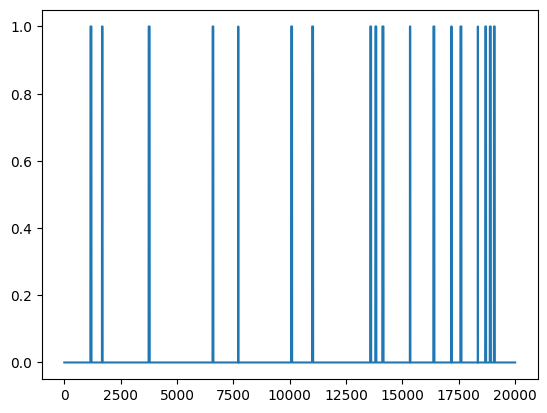

In [780]:
plt.plot(reward)

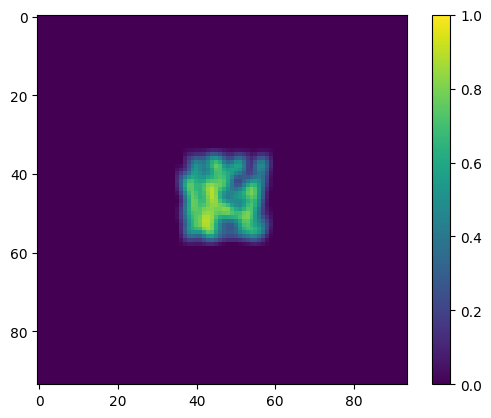

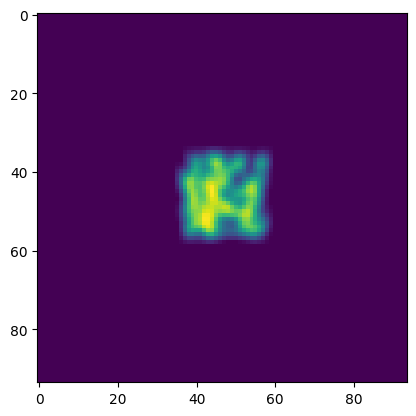

643


In [781]:
firing_map = firing_rate_map(reward, pos, title = '')
plt.imshow(firing_map)
plt.show()
print(sum(reward))

In [782]:
# def old_traj_dat(traj_name, imgs_name):
#     with open(traj_name, "rb") as f:
#         d = pickle.load(f)
#         f.close()

#     obj_present = True
#     x = np.asarray(d['x'])
#     y = np.asarray(d['y'])
#     pos = np.column_stack((x,y))
#     env = [(1.0, -1.0), (1.0, 1.0), (-1.0, 1.0), (-1.0, -1.0), (1.0, -1.0)]
#     obj_c, obj_c_plot = obj_cent(traj_name)

#     hf_sz = 0.15
#     out_bound = 0.07
#     obj_ver = [(c[0]-hf_sz, c[1]-hf_sz, c[0]+hf_sz, c[1]+hf_sz) for c in obj_c]
#     print(obj_ver)
#     obj_ver_outer = [(c[0]-hf_sz-out_bound, c[1]-hf_sz-out_bound, c[0]+hf_sz+out_bound, c[1]+hf_sz+out_bound) for c in obj_c]

#     sq1_env = box(-1.0, -1.0, 1.0, 1.0)
#     sq1 = box(-0.8, -0.8, 0.8, 0.8)
#     sq2 = [box(obj_ver[j][0], obj_ver[j][1], obj_ver[j][2], obj_ver[j][3]) for j in range(len(obj_ver))]
#     sq3 = [box(obj_ver_outer[k][0], obj_ver_outer[k][1], obj_ver_outer[k][2], obj_ver_outer[k][3]) for k in range(len(obj_ver_outer))]
#     k1_env = list(sq1_env.exterior.coords)
#     k1 = list(sq1.exterior.coords)
#     k2 = [list(l.exterior.coords) for l in sq2]
#     k3 = [list(ll.exterior.coords) for ll in sq3]

#     env = [[m[0] for m in k1_env ], [m[1] for m in k1_env ]]
#     obj = [[[m[0] for m in obji ], [m[1] for m in obji ]] for obji in k2]
#     obj_boun = [[[m[0] for m in objbi ], [m[1] for m in objbi ]] for objbi in k3]

#     theta = np.asarray(d['theta'])
#     theta_rad = np.radians(theta)
#     print(max(theta))
#     print(len(theta))

#     ## objects to do plotting that show shifting
#     obj_ver_plot = [(c[0]-hf_sz, c[1]-hf_sz, c[0]+hf_sz, c[1]+hf_sz) for c in obj_c_plot]
#     sq2_plot = [box(obj_ver_plot[j][0], obj_ver_plot[j][1], obj_ver_plot[j][2], obj_ver_plot[j][3]) for j in range(len(obj_ver_plot))]
#     k2_plot = [list(l.exterior.coords) for l in sq2_plot]
#     obj_plot = [[[m[0] for m in obji ], [m[1] for m in obji ]] for obji in k2_plot]

#     # reward around the object
#     plt.show()
#     reward = rew_new(x, y, obj_ver_outer, present = obj_pres)
#     # reward = [float(i) for i in reward]
#     print(len(reward))
#     plt.plot(x,y)
#     ind = [i*30 for i in range(int(len(x)/30))]

#     ###------- Plot reward-------######
#     plt.plot(reward)
#     plt.show()
#     from scipy.ndimage import gaussian_filter
#     import scipy
#     from scipy import signal, ndimage
#     print(np.sum(reward))
#     title = "pred reward without object"
#     firing_map = firing_rate_map(reward[ind], pos[ind], title = title)
#     plt.imshow(firing_map)
#     plt.show()

#     ###------- Load Images -------######
#     print("------------------------Load Images-----------------------------")
#     with open(imgs_name, "rb") as f:
#         train_imgs = pickle.load(f)
#         f.close()

#     print(train_imgs.shape)


#     #### --------- Path Integration  --------####
#     print("------------------Calculate PI------------------------")
#     beta = [3.0*np.pi]
#     pi_lay = PI(x, y, theta_rad, beta, pi_use)

#     return train_imgs, pi_lay, reward, pos

In [783]:
# train_imgs_old, pi_old, reward_old, pos_old = old_traj_dat(traj_o, imgs_o)
# comp_data_old = [train_imgs_old, pi_old]

In [784]:
def custom_weight_loss(y_true, y_pred):
  global alp, bet, gam
  y_diff = y_true - y_pred
  y_sq = tf.square(y_diff)

  # alp_mat = alp*tf.ones(tf.shape(y_sq[:, :22])) 
  # bet_mat = bet*tf.ones(tf.shape(y_sq[:, 22:33])) 
  # gam_mat = tf.expand_dims(gam*tf.ones(tf.shape(y_sq[:, -1])), axis=1) 
  # print(alp_mat.shape)
  # print(bet_mat.shape)
  # print(gam_mat.shape)
  # weighted_ratios = tf.concat([alp_mat, bet_mat, gam_mat], axis=1)
  # print(tf.shape(weighted_ratios))
  # y_loss = tf.math.multiply(weighted_ratios, y_sq)
  t_loss = alp*tf.reduce_mean(y_sq[:,:22]) + bet*tf.reduce_mean(y_sq[:,22:33]) + gam*tf.reduce_mean(y_sq[:,-1])

  return t_loss

In [785]:
# from tensorflow.keras.models import load_model
# model_chk = load_model(fol + old_model_n +".h5", custom_objects={'GraphConv':GraphConv, 'custom_weight_loss':custom_weight_loss})

# MODEL

### Setup Architecture

In [786]:
def model_arch(data, nodes, nodes2, activ, lr):
  print("#########-----------------TRAINING MODEL---------------#########")
  act = 'leaky_relu'
  input_img = Input(shape = data[0].shape[1:], name="IMAGE")
  input_pi = Input(shape = data[1].shape[1], name="PI")

  encoder = Conv2D(4, (5, 5), padding='same', activation= act, name="CONV_1")(input_img)
  encoder = MaxPooling2D(pool_size=(8,8), padding='same', name="MAXPOOL_1")(encoder)
  flatencoder=Flatten()(encoder)
  #flatencoder = GlobalAveragePooling2D()(encoder)
  dense0 = Dense(nodes, activation = 'leaky_relu', name='LEC')(flatencoder)
  dense_pi1 = Dense(nodes, activation= 'leaky_relu', name='MEC')(input_pi)
  dense_pi1 = layers.Reshape((1,nodes))(dense_pi1)
  dense0 = layers.Reshape((1,nodes))(dense0)
  data_layer = layers.concatenate([dense0, dense_pi1], axis=1)
  print(data_layer.shape)

  edge_layer = tf.constant(np.matlib.repmat(np.asarray([[1/3,1/3], [1/3,1/3]]), 1, 1).reshape((1,2,2)))
  conv_layer = GraphConv(units=nodes, step_num=1)([data_layer, edge_layer])
  conv_layer0 = Flatten()(conv_layer)
  dense1 = Dense(nodes2, activation = activ, name = 'D1')(conv_layer0)
  # dense1 = BatchNormalization()(dense1)
  dense2 = Dense(nodes2, activation = activ, name = 'D2')(dense1)
  dense3 = Dense(nodes2, activation = activ, name = 'D3')(dense2)
  # dense4 = Dense(8, activation = activ, name = 'D4')(dense3)

  output1 = Dense(22, activation='tanh', name='VALUE1')(dense3)
  output2 = Dense(11, activation='tanh', name='VALUE2')(dense3)
  output3 = Dense(1, activation='tanh', name='VALUE3')(dense3)
  output = layers.concatenate([output1, output2, output3], axis=1)
  #
  regressor_model = Model([input_img, input_pi], output)
  #regressor_model = Model([input_img,], [outputx, outputy, outputz])
  opt = tf.keras.optimizers.Adam(learning_rate= lr)
  regressor_model.compile(optimizer=opt, loss = custom_weight_loss, )
  # regressor_model.summary()

  return regressor_model

In [787]:
def model_arch_catas(data, old_mod_dict, nodes, nodes2, lam, activ, ):
  tf.keras.backend.clear_session()

  old_wts = old_mod_dict["weights"]
  I = old_mod_dict["fisher"]

  print("#########-----------------RETRAINING MODEL---------------#########")
  act = 'leaky_relu'
  input_img = Input(shape = data[0].shape[1:], name="IMAGE")
  input_pi = Input(shape = data[1].shape[1], name="PI")

  encoder = Conv2D(4, (5, 5), padding='same', activation= act, name="CONV_1", kernel_regularizer=ewc_reg(I[0], old_wts[0], Lambda = lam),
                   bias_regularizer = ewc_reg(I[1], old_wts[1], Lambda = lam))(input_img)
  encoder = MaxPooling2D(pool_size=(8,8), padding='same', name="MAXPOOL_1")(encoder)
  # encoder = Conv2D(4, (5, 5), padding='same', activation= act, name="CONV_2", kernel_regularizer=ewc_reg(I[2], old_wts[2], Lambda = lam),
                  #  bias_regularizer = ewc_reg(I[3], old_wts[3], Lambda = lam))(encoder)
  # encoder = MaxPooling2D(pool_size=(2,2), padding='same', name="MAXPOOL_2")(encoder)
  # encoder = Conv2D(2, (5, 5), padding='same', activation= act, name="CONV_3", kernel_regularizer=ewc_reg(I[4], old_wts[4], Lambda = lam),
  #                  bias_regularizer = ewc_reg(I[5], old_wts[5], Lambda = lam))(encoder)
  # encoder = MaxPooling2D(pool_size=(2,2), padding='same', name="MAXPOOL_3")(encoder)
  flatencoder = Flatten()(encoder)
  #flatencoder = GlobalAveragePooling2D()(encoder)
  dense0 = Dense(nodes, activation = 'leaky_relu', name='LEC', kernel_regularizer=ewc_reg(I[2], old_wts[2], Lambda = lam),
                 bias_regularizer = ewc_reg(I[3], old_wts[3], Lambda = lam))(flatencoder)
  # dense1 = Dense(50, activation = act, name='LEC2')(dense0)
  # dense0 = Dropout(0.5)(dense0)
  dense_pi1 = Dense(nodes, activation= 'leaky_relu', name='MEC', kernel_regularizer=ewc_reg(I[4], old_wts[4], Lambda = lam),
                    bias_regularizer = ewc_reg(I[5], old_wts[5], Lambda = lam))(input_pi)
  # dense_pi2 = Dense(50, activation= act, name='MEC2')(dense_pi1)
  # concat = layers.concatenate([dense1, dense_pi2])
  dense_pi1 = layers.Reshape((1,nodes))(dense_pi1)
  dense0 = layers.Reshape((1,nodes))(dense0)
  data_layer = layers.concatenate([dense0, dense_pi1], axis=1, name = "Concat")
  print(data_layer.shape)
  # edge_layer = layers.Input(shape=(None, None))
  edge_layer = tf.constant(np.matlib.repmat(np.asarray([[1/3,1/3], [1/3,1/3]]), 1, 1).reshape((1,2,2)))
  # edge_layer = tf.constant(np.asarray([[0,1], [1,0.]]).reshape((1,2,2)))
  conv_layer = GraphConv(units=nodes, step_num=1, kernel_regularizer=ewc_reg(I[6], old_wts[6], Lambda = lam),
                         bias_regularizer = ewc_reg(I[7], old_wts[7], Lambda = lam), name = "graph_conv")([data_layer, edge_layer])
  # conv_layer = Dropout(0.5)(conv_layer)
  # conv_layer0 = layers.Add()([conv_layer[:,0,:],conv_layer[:,1,:]])
  conv_layer0 = Flatten()(conv_layer)
  dense1 = Dense(nodes2, activation=activ, name = 'D1', kernel_regularizer=ewc_reg(I[-12], old_wts[-12], Lambda = lam),
                 bias_regularizer = ewc_reg(I[-11], old_wts[-11], Lambda = lam))(conv_layer0)
  dense2 = Dense(nodes2, activation=activ, name = 'D2', kernel_regularizer=ewc_reg(I[-10], old_wts[-10], Lambda = lam),
                 bias_regularizer = ewc_reg(I[-9], old_wts[-9], Lambda = lam))(dense1)
  dense3 = Dense(nodes2, activation=activ, name = 'D3', kernel_regularizer=ewc_reg(I[-8], old_wts[-8], Lambda = lam),
                 bias_regularizer = ewc_reg(I[-7], old_wts[-7], Lambda = lam))(dense2)
  # dense4 = Dense(8, activation=activ, name = 'D4', kernel_regularizer=ewc_reg(I[-4], old_wts[-4], Lambda = lam),
  #                bias_regularizer = ewc_reg(I[-3], old_wts[-3], Lambda = lam))(dense3)
  # dense4 = Dense(50, activation=act, name = 'D4')(dense3)

  # output1 = Dense(34, activation='tanh', name='VALUE1', kernel_regularizer=ewc_reg(I[-2], old_wts[-2], Lambda = lam),
  #                 bias_regularizer = ewc_reg(I[-1], old_wts[-1], Lambda = lam))(dense3)
  # output2 = Dense(1, activation='linear', name='VALUE2')(conv_layer[:,1,:])
  #
  output1 = Dense(22, activation='tanh', name='VALUE1', kernel_regularizer=ewc_reg(I[-6], old_wts[-6], Lambda = lam),
                 bias_regularizer = ewc_reg(I[-5], old_wts[-5], Lambda = lam))(dense3)
  output2 = Dense(11, activation='tanh', name='VALUE2', kernel_regularizer=ewc_reg(I[-4], old_wts[-4], Lambda = lam),
                 bias_regularizer = ewc_reg(I[-3], old_wts[-3], Lambda = lam))(dense3)
  output3 = Dense(1, activation='tanh', name='VALUE3', kernel_regularizer=ewc_reg(I[-2], old_wts[-2], Lambda = lam),
                 bias_regularizer = ewc_reg(I[-1], old_wts[-1], Lambda = lam))(dense3)
  output = layers.concatenate([output1, output2, output3], axis=1)
  model_r = Model([input_img, input_pi], output)
  # model_r.summary()

  return model_r

In [788]:
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.regularizers import l2
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.constraints import max_norm

def custom_lr_loss(y_true, y_pred):
  global lr_p
  global lr_m
  y_true = tf.cast(y_true, tf.float32)
  y_diff = y_true - y_pred
  y_sq = tf.square(y_diff)

  lr_mat = lr_p*y_true + lr_m*(1-y_true)
  y_loss = tf.math.multiply(lr_mat, y_sq)
  t_loss = tf.reduce_mean(y_loss)

  return t_loss


def custom_weight_loss(y_true, y_pred):
  global alp, bet, gam
  y_diff = y_true - y_pred
  y_sq = tf.square(y_diff)

  # alp_mat = alp*tf.ones(tf.shape(y_sq[:, :22])) 
  # bet_mat = bet*tf.ones(tf.shape(y_sq[:, 22:33])) 
  # gam_mat = tf.expand_dims(gam*tf.ones(tf.shape(y_sq[:, -1])), axis=1) 
  # print(alp_mat.shape)
  # print(bet_mat.shape)
  # print(gam_mat.shape)
  # weighted_ratios = tf.concat([alp_mat, bet_mat, gam_mat], axis=1)
  # print(tf.shape(weighted_ratios))
  # y_loss = tf.math.multiply(weighted_ratios, y_sq)
  t_loss = alp*tf.reduce_mean(y_sq[:,:22]) + bet*tf.reduce_mean(y_sq[:,22:33]) + gam*tf.reduce_mean(y_sq[:,-1])

  return t_loss

# Train the model 
if Train:
  tf.keras.backend.clear_session()
  model = model_arch(comp_data, nodes = units, nodes2=units2, activ = 'leaky_relu', lr = lr_schedule)
  model.summary()


## If retrain the model
if Retrain:
  opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

  if Retrain_nocat:
    keras.backend.clear_session()
    model = model_arch(comp_data, nodes = units, nodes2=units2, activ = 'leaky_relu', lr = learn_rate)

    # if custom_loss_func:
    #   opt = tf.keras.optimizers.SGD(learning_rate = 1.0)
    #   model.compile(optimizer = opt, loss = custom_lr_loss, )
    # else:
    #   model.compile(optimizer = opt, loss = 'mse', )


  else:
    
    # with open(fol+"mod_dict_" + old_model_n + ".pk1", "rb") as f:
    with open(fol+ "mod_dict_" + old_model_n +".pk1", "rb") as f:
      old_mod_dict = pickle.load(f)
      f.close()
    
    model = model_arch_catas(comp_data, old_mod_dict, nodes=units, nodes2=units2, lam=lam, activ = 'leaky_relu')
    model.compile(optimizer = opt, loss = custom_weight_loss, )

    # if custom_loss_func:
    #   opt = tf.keras.optimizers.SGD(learning_rate = 1.0)
    #   model.compile(optimizer = opt, loss = custom_lr_loss, )
    # else:
    #   model.compile(optimizer = opt, loss = 'mse', )
  
  print("Loading weights from previous model")
  model.load_weights(fol + old_model_n +".h5")
  model.summary() 

### Train the model

In [789]:
if Train:  
  train_dat = [sub_imgs_t[0], sub_pi_t[0]]
  train_tar = sub_tar_t[0]

  ii = 0
  # for ii in range(1):
  while True:
      num_images = pos[0]-1
      loss = []
      val_loss = []
      history = model.fit(
                train_dat,
                train_tar,
                epochs = 1,
                batch_size = 256 ,
                validation_data = ([sub_imgs_t[1], sub_pi_t[1]], sub_tar_t[1]),
                shuffle = True,
                verbose = 2)
      
      ii+=1  
      print(ii)
      
      if (history.history['loss'][0] < 10**-3 and history.history['val_loss'][0] < 10**-3) or ii > epochs:
        break

  model.save(fol+ new_model_n +".h5")
  wts = model.weights
  print(wts[-1])

## Retrain the model

In [790]:
if Retrain:
  error_x = []
  error_y = []
  error_a = []
  # error_old = []

  train_dat = [sub_imgs_t[0], sub_pi_t[0]]
  train_tar = sub_tar_t[0]

  # predicted_r = model.predict(comp_data)
  # predicted_r_old = model.predict(comp_data_old)
  # firing_rate_map(predicted_r[ind], pos[ind])

  # error_current.append(mse(predicted_r,reward))
  # error_old.append(mse(predicted_r_old,reward_old))

  # for ii in range(epochs)):
  ii = 0
  while True:
      num_images = pos[0]-1
      loss = []
      val_loss = []
      history = model.fit(
                train_dat,
                train_tar,
                epochs = 1,
                batch_size = 256 ,
                validation_data = ([sub_imgs_t[1], sub_pi_t[1]], sub_tar_t[1]),
                shuffle = True, verbose=2)
      
      ii+=1  
      print(ii)
      predicted_r = model.predict(comp_data)
      curr_err = mse(predicted_r[:,-1], reward)
      if not Retrain_nocat:
        mod_lays = model.layers
        reg_loss_arr = [ll.losses[0] for ll in mod_lays if len(ll.losses)]
        reg_loss_tot = (K.eval(sum(reg_loss_arr)))/len(reg_loss_arr)
        print("loss from regularizer: " + str(reg_loss_tot/lam))
        print('loss from model:' + str(curr_err))
        # if (history.history['loss'][0] < 10**-3 and history.history['val_loss'][0] < 10**-3 and (reg_loss_tot/lam) < 10**-4) or ii > epochs:
        if (curr_err < 10**-3 and (reg_loss_tot/lam) < 10**-4) or ii>epochs:
          break
      
      if Retrain_nocat:
        if (history.history['loss'][0] < 10**-3 and history.history['val_loss'][0] < 10**-3) or ii > epochs:
          break
      # if ii % 10 == 0:

      # error_x.append(mse(xya_pred[:,0],tar[:,0]))
      # error_y.append(mse(xya_pred[:,1],tar[:,1]))
      # error_a.append(mse(xya_pred[:,2],tar[:,2]))
      # predicted_r_old = model.predict(comp_data_old)
      # error_old.append(mse(predicted_r_old,reward_old))
      # plt.plot(error_current, label='error_c')
      # plt.plot(error_old, label='error_o')
      # plt.show()
      # print(error_current[-1])

      # if not Retrain_nocat:
      # if True:
      #   if True:
      #   # if ii % 10 == 0:
      #     plt.legend()
      #     plt.show()

      #     lr_p = lr_p*0.98
      #     lr_m = lr_m*0.99
      #     print('it came here')
      #     model.save(fol+ new_model_n +".h5")
      #     wts = model.weights

      #     keras.backend.clear_session()
      #     model = model_arch_catas(train_dat, old_mod_dict, nodes=units, nodes2 = units2, lam = lam, activ = 'sigmoid')
      #     model.compile(optimizer = opt, loss = 'mse', )
      #     print("Loading weights from previous model")
      #     model.load_weights(fol+ new_model_n +".h5")

      # firing_rate_map(predicted_r[ind], pos[ind], ticks_colbar = np.linspace(0, 1, 5))  

  model.save(fol+ new_model_n +".h5")
  wts = model.weights
  print(wts[-1])

In [791]:
# if Retrain:
#   plt.plot(error_current, label='error_c')
#   plt.plot(error_old, label='error_o')
#   plt.legend()
#   plt.grid()
#   plt.show()
#   print(error_current[-1])

# LAYERWISE OUTPUT ANALYSIS

In [792]:
tf.keras.backend.clear_session()
autoencoder_model = model_arch(comp_data, nodes = units, nodes2=units2, activ = 'leaky_relu', lr = lr_schedule)
autoencoder_model.load_weights(fol+ new_model_n +".h5")
outputs  = [layer.output for layer in autoencoder_model.layers]
encoded = {}

#########-----------------TRAINING MODEL---------------#########
(None, 2, 32)


In [793]:
predicted_r = autoencoder_model.predict(comp_data)

625/625 [==============================] - 2s 3ms/step


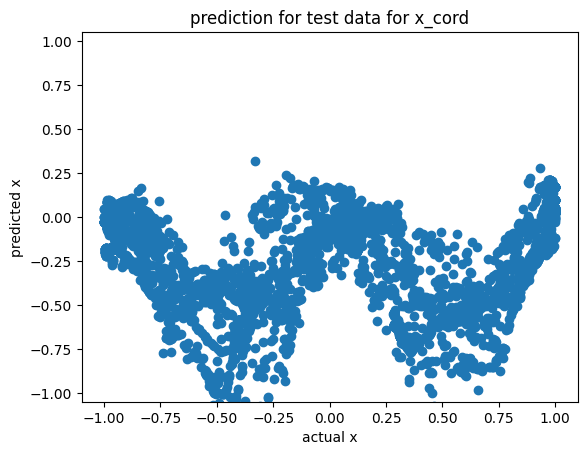

mse error in x: 0.6355346684760149



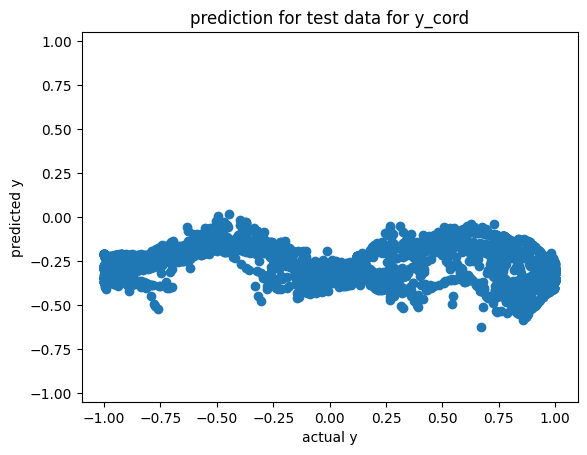

mse error in y: 0.6408738384255098



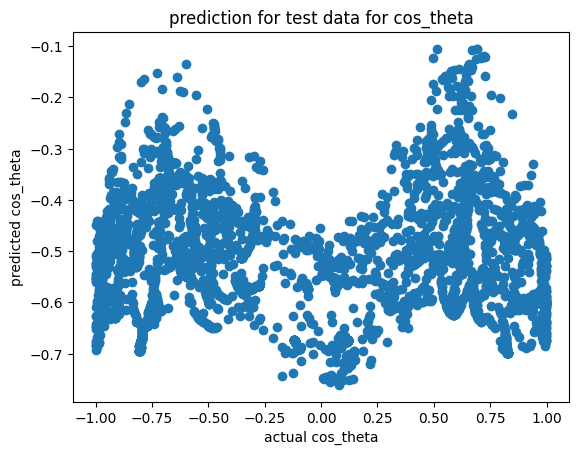

mse error in cos: 0.73155852163917



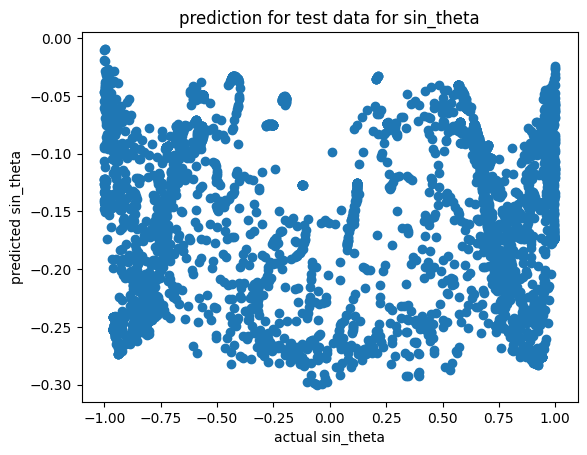

mse error in sin: 0.5860068232342001



In [794]:
k = predicted_r
seq_len = 1
test = False
temp_x_num = np.sum(np.multiply(xi,k[:,:11]), axis = 1)
temp_x_den = np.sum(k[:, :11], axis = 1)
temp_y_num = np.sum(np.multiply(yi,k[:,11:22]), axis = 1)
temp_y_den = np.sum(k[:, 11:22], axis = 1)
temp_theta_num = np.matmul(k[:,22:-1], ui)*2/11
x_pred = temp_x_num/temp_x_den
y_pred = temp_y_num/temp_y_den

sub_x_pred = train_test_split(x_pred, test_size=0.2, random_state=random_state)
sub_x = train_test_split(x, test_size=0.2, random_state=random_state)
sub_y_pred = train_test_split(y_pred, test_size=0.2, random_state=random_state) 
sub_y = train_test_split(y, test_size=0.2, random_state=random_state) 
sub_Hd_rep = train_test_split(Hd_rep, test_size=0.2, random_state=random_state)
sub_temp_theta_num = train_test_split(temp_theta_num, test_size=0.2, random_state=random_state)

temp = np.column_stack((sub_x[0], sub_x_pred[0]))
# print(temp[:30])

test = 1
plt.scatter(sub_x[test], sub_x_pred[test])
if test:
  plt.title("prediction for test data for x_cord")
else:
  plt.title("prediction for train data for x_cord")
plt.xlabel("actual x")
plt.ylabel("predicted x")
plt.ylim(-1.05,1.05)
plt.show()
error_x = mse(sub_x[test],sub_x_pred[test])
print("mse error in x:",error_x)
print("")


plt.scatter(sub_y[test], sub_y_pred[test])
if test:
  plt.title("prediction for test data for y_cord")
else:
  plt.title("prediction for train data for y_cord")
plt.xlabel("actual y")
plt.ylabel("predicted y")
plt.ylim(-1.05,1.05)
plt.show()
error_y = mse(sub_y[test],sub_y_pred[test])
print("mse error in y:",error_y)
print("")


plt.scatter(sub_Hd_rep[test][:,0], sub_temp_theta_num[test][:,0])
if test:
  plt.title("prediction for test data for cos_theta")
else:
  plt.title("prediction for train data for cos_theta")
plt.xlabel("actual cos_theta")
plt.ylabel("predicted cos_theta")
plt.show()
error_cos = mse(sub_Hd_rep[test][:,0], sub_temp_theta_num[test][:,0])
print("mse error in cos:" ,error_cos)
print("")


plt.scatter(sub_Hd_rep[test][:,1], sub_temp_theta_num[test][:,1])
if test:
  plt.title("prediction for test data for sin_theta")
else:
  plt.title("prediction for train data for sin_theta")
plt.xlabel("actual sin_theta")
plt.ylabel("predicted sin_theta")
plt.show()
error_sin = mse(sub_Hd_rep[test][:,1], sub_temp_theta_num[test][:,1])
print("mse error in sin:" ,error_sin)
print("")
##

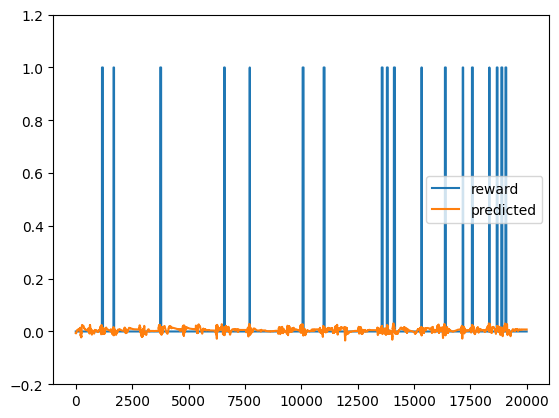

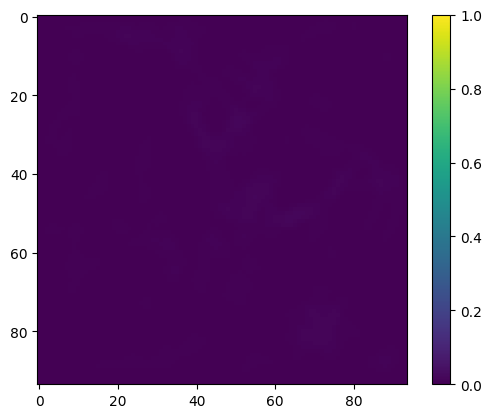

In [795]:
plt.plot(reward, label = 'reward')
plt.plot(predicted_r[:,-1], label = 'predicted')
plt.ylim([-0.2,1.2])
plt.legend()
plt.show()

from scipy.ndimage import gaussian_filter
import scipy
from scipy import signal, ndimage
#ot = predicted_output[1][:,-1,:]
#ot = gt
# ot = np.ndarray.flatten(encoded['val'])
# predicted_r_old = autoencoder_model.predict(comp_data_old)
# firing_map = firing_rate_map(predicted_r_old, pos_old)
firing_map = firing_rate_map(predicted_r[:,-1], pos)

#### Save & load layerwise output

In [796]:
inp = autoencoder_model.input
lay_nam = ['D1', 'D2','D3', 'LEC', 'MEC', 'graph_conv']

encoded_pre = {}

for i in range(len(lay_nam)):
  layer_output = autoencoder_model.get_layer(lay_nam[i]).output
  functor = K.function(inp, layer_output)
  temp1 = functor(comp_data)
  if lay_nam[i] == 'graph_conv':
    encoded_pre['graph_LEC'] = temp1[:,0,:]
    encoded_pre['graph_MEC'] = temp1[:,1,:]
  else:
    encoded_pre[lay_nam[i]] = temp1

In [797]:
with open(fol+"lay_out_train_6" + ".pk1", 'wb') as ff:
    pickle.dump(encoded_pre, ff)
    ff.close()

In [798]:
# def firing_rate_map(ot, all_dat, thresh_param = 0.0, title="", ticks_colbar = None, res_param = 45, sub_plot = False):
#     res = res_param
#     mean_resp = np.mean(ot)
#     std_resp = np.std(ot)
#     thresh = mean_resp + (thresh_param * std_resp)
#     # thresh = np.max(ot)*thresh_param
#     firr = np.nonzero(ot>thresh)
#     firposgrid = all_dat[firr[0], :]
#     #firr = list(firr[0])
#     x = np.arange(-1, 1, 1/res)
#     y = np.arange(-1, 1, 1/res)
#     fx,fy = np.meshgrid(x, y)
#     firingmap = np.zeros(fx.shape)
#     firingvalue = ot[firr]
#     for ii in range(len(firposgrid)):
#         q1 = np.argmin(abs(firposgrid[ii,0] - fx[1,:]))
#         q2 = np.argmin(abs(firposgrid[ii,1] - fy[:,1]))
#         firingmap[q1,q2] = firingvalue[ii]
#     firingmap = firingmap/max(np.max(firingmap),1)
#     gaussian = matlab_style_gauss2D([5, 5], 1.5)
#     spikes_smooth = scipy.signal.convolve2d(gaussian, firingmap)
#     rotated_img = ndimage.rotate(spikes_smooth, 1*90)
#     if not sub_plot:
#       plt.imshow(rotated_img, origin= 'upper')
#       plt.title(title)
#       plt.colorbar(ticks = ticks_colbar)
#       # plt.clim(0,1)
#       ax=plt.gca()                            # get the axis
#       # ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
#       # ax.set_xlim(ax.get_xlim()[::-1])        # invert the axis
#       plt.show()
#       # ax.xaxis.tick_bottom()                     # and move the X-Axis
#       # ax.set_yticklabels([])
#       # ax.set_xticklabels([])

#     return rotated_img

In [799]:
# GET OUTPUT FOR THE REQUIRED LAYERS
ind = [i*30 for i in range(int(len(x)/30))]

if pre_conv:
  inp = autoencoder_model.input
  lay_nam = ['D1', 'D2','D3', 'LEC', 'MEC', 'graph_conv']
  lim = [0.0]*7#, 0.5, 0.0]#, 0.4, 0.4]

  encoded_pre = {}

  for i in range(len(lay_nam)):
    layer_output = autoencoder_model.get_layer(lay_nam[i]).output
    functor = K.function(inp, layer_output)
    temp1 = functor(comp_data)
    if lay_nam[i] == 'graph_conv':
      encoded_pre['graph_LEC'] = temp1[:,0,:]
      encoded_pre['graph_MEC'] = temp1[:,1,:]
    else:
      encoded_pre[lay_nam[i]] = temp1

  from matplotlib.pyplot import close
  outs = lay_nam[:-1] + ['graph_LEC', 'graph_MEC']
  outs_n = lay_nam[:-1] + ["gr_LEC", "gr_MEC"]#, 'CA1']#, "CA1", "CA3"]
  pos_out = pos

  for k in range(len(outs)):
    if outs[k] == 'rnn_1' or 'rnn_2':
      resp_neurons = np.transpose(np.squeeze((encoded_pre[outs[k]])))
    else:
      resp_neurons = np.squeeze(np.transpose(encoded_pre[outs[k]]))
    avg = np.mean(abs(resp_neurons))
    std_dev = np.std(resp_neurons)
    m = np.amax(resp_neurons)
    num = 0
    for j in range(int(np.divide(len(resp_neurons),resp_neurons.shape[0]))):
        onm = outs_n[k]
        for i in range(resp_neurons.shape[0]):
            axarr = plt.subplot(8,8,i+1)
            img_dat = firing_rate_map(resp_neurons[i+num], pos_out, thresh_param=lim[k], res_param=45, sub_plot=True)
            axarr.imshow(img_dat)

            # plt.plot(env[0], env[1])
            plt.suptitle('output mesh with obj '+str(num)+ ' to '+str(num+resp_neurons.shape[0])+' neurons from '+ onm +' layer, threshold=' +str(lim[k])+" act_func=" + "relu", fontsize = 20, va = 'bottom', ha = 'center')

        num = num + resp_neurons.shape[0]
        figure = plt.gcf() # get current figure
        figure.set_size_inches(14, 10)
        plt.savefig(fol + onm + "_" + str(traj1)[:-4] + "_" + str(num), bbox_inches='tight')
        plt.show()
        close()


In [800]:
# firing_map = firing_rate_map(encoded_pre['D1'][:,30], pos, thresh_param=1.0, res_param=100)
# labels, num_labels = ndimage.label(firing_map>0.1)

In [801]:
# plt.imshow(firing_map[5:-5, 5:-5])

In [802]:
# print(num_labels)
# sizes = np.bincount(labels.flatten())
# border_fields = np.zeros_like(firing_map, dtype=bool)
# plt.imshow(firing_map)
# plt.show()
# border_fields |= (labels==np.argmax(sizes))
# plt.imshow(border_fields[:, :-4 ])
# plt.show()

In [803]:
# GET OUTPUT FOR THE REQUIRED LAYERS
if pre_conv:
  inp = autoencoder_model.input
  # lay_nam = ['D1', 'D2', 'graph_conv']
  # lim = [1.0, 1.0]#, 0.5, 0.0]#, 0.4, 0.4]
  lay_nam = ['D1', 'D2', 'D3', 'LEC', 'MEC', 'graph_conv']
  lim = [1.5]*7 #, 0.5, 0.0]#, 0.4, 0.4]

  # lim = [1.5, 1.5, 1.5, 2.0, 1.5, 1.5, 1.5]#, 0.5, 0.0]#, 0.4, 0.4]

  encoded_pre = {}

  for i in range(len(lay_nam)):
    layer_output = autoencoder_model.get_layer(lay_nam[i]).output
    functor = K.function(inp, layer_output)
    temp1 = functor(comp_data)
    if lay_nam[i] == 'graph_conv':
      encoded_pre['graph_LEC'] = temp1[:,0,:]
      encoded_pre['graph_MEC'] = temp1[:,1,:]
    else:
      encoded_pre[lay_nam[i]] = temp1



  from matplotlib.pyplot import close
  outs = lay_nam[:-1] + ['graph_LEC', 'graph_MEC']
  outs_n = lay_nam[:-1] + ["gr_LEC", "gr_MEC"]#, 'CA1']#, "CA1", "CA3"]
  pos_out = pos

  for k in range(len(outs)):
    if outs[k] == 'rnn_1' or 'rnn_2':
      resp_neurons = np.transpose(np.squeeze((encoded_pre[outs[k]])))
    else:
      resp_neurons = np.squeeze(np.transpose(encoded_pre[outs[k]]))
    avg = np.mean(abs(resp_neurons))
    std_dev = np.std(resp_neurons)
    m = np.amax(resp_neurons)
    num = 0
    for j in range(int(np.divide(len(resp_neurons),resp_neurons.shape[0]))):
        onm = outs_n[k]
        for i in range(resp_neurons.shape[0]):
            plt.subplot(8,8,i+1)
            mean_resp = np.mean(resp_neurons[i+num])
            std_resp = np.std(resp_neurons[i+num])
            thresh = mean_resp + (lim[k] * std_resp)
            # thresh = np.amax(resp_neurons[i+num]) * lim[k]
            firr = np.nonzero(resp_neurons[i+num]>thresh)
            firposgrid = pos_out[firr[0], :]
            plt.scatter(firposgrid[:,0], firposgrid[:,1], s = 3, color = 'red', marker='o', zorder = 5)
            if obj_pres:
              for tt in range(len(obj_plot)):
                if tt == len(obj_plot)-1:
                  plt.plot(obj_plot[tt][0], obj_plot[tt][1], 'b')
                else:
                  plt.plot(obj_plot[tt][0], obj_plot[tt][1],'--', 'b')
            else:
              for tt in range(len(obj_plot)):
                plt.plot(obj_plot[tt][0], obj_plot[tt][1],'--', 'b')

            plt.plot(env[0], env[1])
            plt.suptitle('output mesh with obj '+str(num)+ ' to '+str(num+resp_neurons.shape[0])+' neurons from '+ onm +' layer, threshold=' +str(lim[k])+" act_func=" + "relu", fontsize = 20, va = 'bottom', ha = 'center')

        num = num + resp_neurons.shape[0]
        figure = plt.gcf() # get current figure
        figure.set_size_inches(14, 10)
        plt.savefig(fol + onm + "_red"  + str(traj1)[:-4] + "_" + str(num), bbox_inches='tight')
        plt.show()
        close()


### Fisher Compute

In [804]:
def computer_fisher(model, imgset):
  with tf.GradientTape(persistent=True) as gt:
      f_accum = []
      for i in range(len(model.weights)):
          f_accum.append(np.zeros(model.weights[i].shape))
      f_accum = np.array(f_accum)

      for j in range(len(imgset[0])):
          img_index = j
          # input_mod = np.expand_dims(imgset[img_index],0)
          input_mod = [np.expand_dims(imgset[0][j],0), np.expand_dims(imgset[1][j],0)]
          # print(input_mod)
          model_output = model(input_mod)
          grads = gt.gradient(model_output, model.weights)

          f_accum += np.square(grads)
          # print(f_accum)
          if j%200 == 0:
            print(j)
          # pbar.update(j+1)
      # pbar.finish()
      # f_accum /= len(imgset)
  # del gt
  return f_accum

In [805]:
if Do_fisher:
  # img_ind = np.where(sub_r_t[0] == 1)
  # img_ind = [[]]
  
  train_dat = [sub_imgs_t[0][:-200], sub_pi_t[0][:-200]]
  train_tar = sub_tar_t[0]

  print('Processing Fisher Information...')
  I_new = computer_fisher(autoencoder_model, train_dat)
  I_new = I_new / len(train_dat[0])
  print('Processing Finish!')
  # hist_ = history.history

  # I_new = New_I.copy()
  New_I = I_new.copy()
  j = 0
  while j < len(New_I):
    max_w = np.amax(New_I[j])
    max_b = np.amax(New_I[j+1])
    max_t = max(max_w, max_b)

    if max_t == 0:
      print("dekne k liye idhar aaya kya")
      New_I[j] = New_I[j]/(max_t + 0.00001)
      New_I[j+1] = New_I[j+1]/(max_t + 0.00001)
    else:
      New_I[j] = New_I[j]/max_t
      New_I[j+1] = New_I[j+1]/max_t
    
    j = j+2

  if Train or Retrain_nocat:
    I_tot = New_I
  else: 
    if Retrain:
      I = old_mod_dict["fisher"]
    I_tot = I + New_I

  model_dict = {"weights": wts, "fisher": I_tot} #, "history": hist_} 
  with open(fol+"mod_dict_" + new_model_n + ".pk1", 'wb') as ff:
      pickle.dump(model_dict, ff)
      ff.close()

In [806]:
if Do_fisher:
  # if Retrain:
  for i in range(len(I_new)):
    print(np.amax(I_tot[i]))
    # print(np.amax(I_new[i]))
    # print(np.amax(I_new[i]))
    # print(I_tot[i])
    # print(np.amax(wts[i]))

#### Plotting layer wise output

------------------------------


------------------------------


------------------------------

0


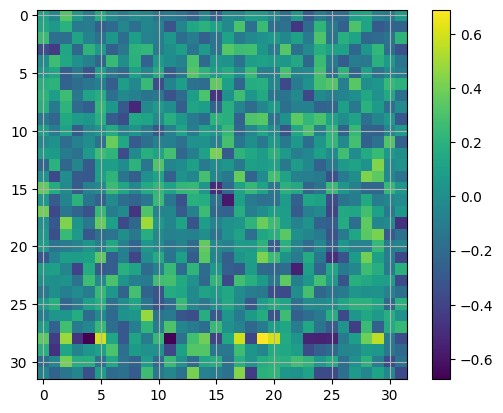

In [807]:
from pylab import *
layer_weight = autoencoder_model.get_layer("graph_conv").get_weights()
A = layer_weight[0]
figure(1)
imshow(A)
colorbar()
grid(True)
print(np.count_nonzero(A == 0))

In [808]:
# plt.rcParams['figure.figsize'] = [30,5]
# plt.rcParams['font.size'] = 20
# plt.plot(encoded["MEC"][:,17])
# plt.plot(reward)
# plt.show()
# close()

In [809]:
# A.reshape(1,2500)
# plt.hist(A)
# plt.show()